# Stock analysis

## Import

Libraries

In [8]:
from utils.init import *

from utils.analyse_price import *
from utils.analyse_fundamentals import *
from utils.data import *
from utils.params import *
from utils.pdf import *

In [9]:
historical_prices_dict = {}

In [10]:
TICKER = 'QQQ'
MARKET = 'US'
first_end_of_quarter = '2020-09'
last_end_of_quarter = '2024-09'

## Get data

Run data

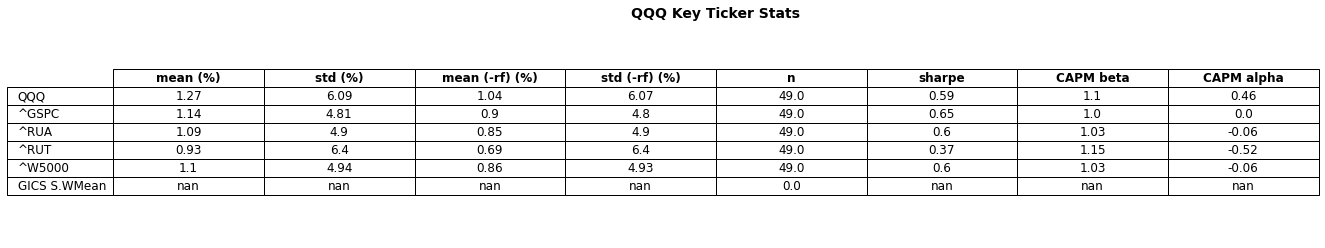

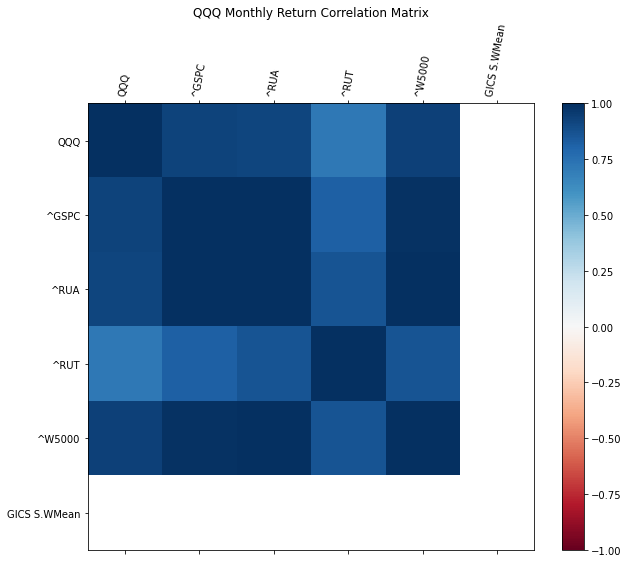

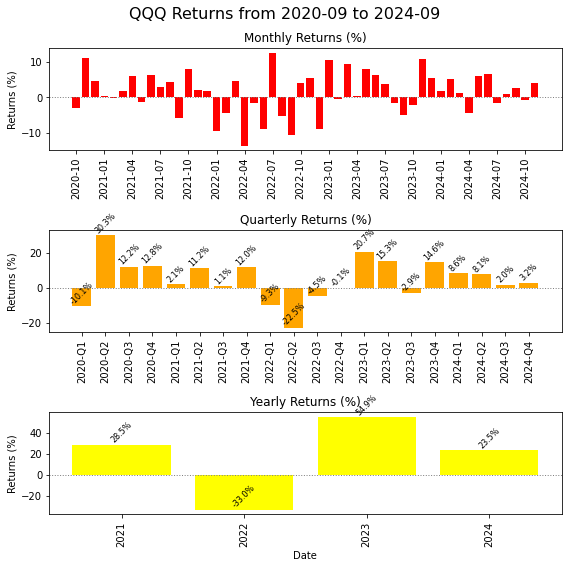

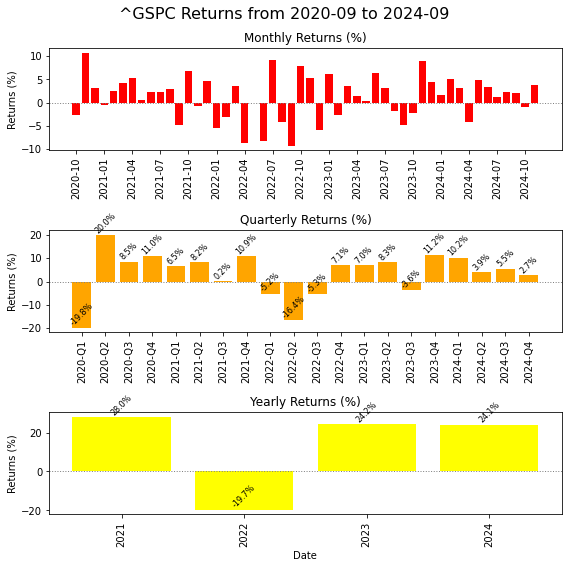

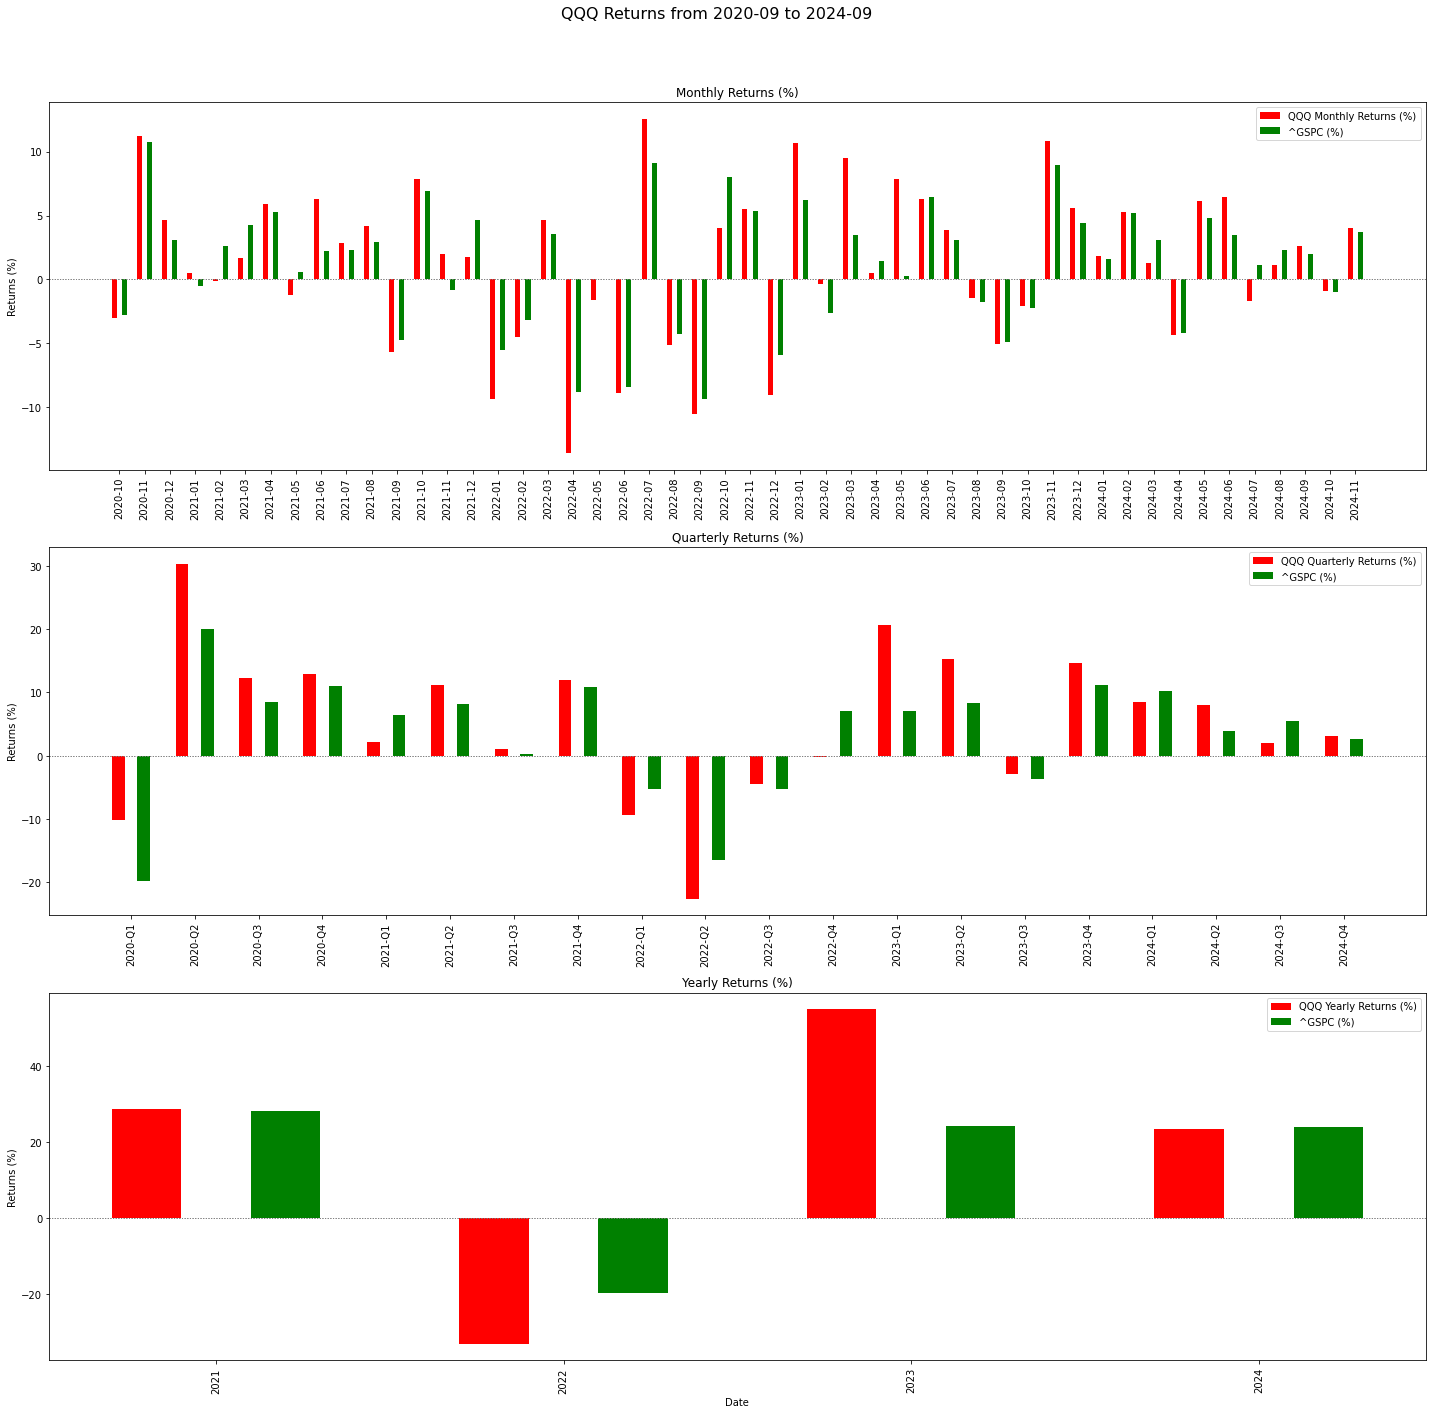

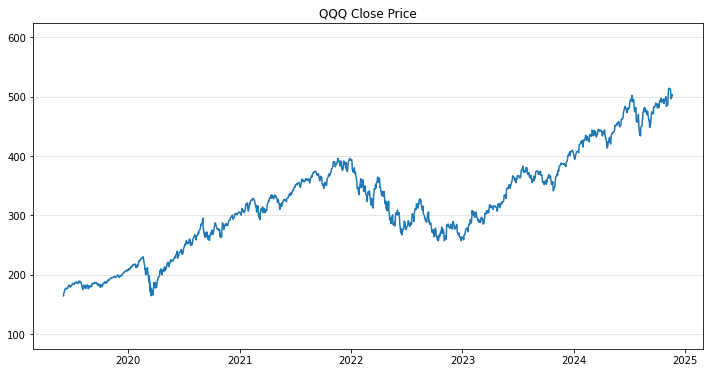

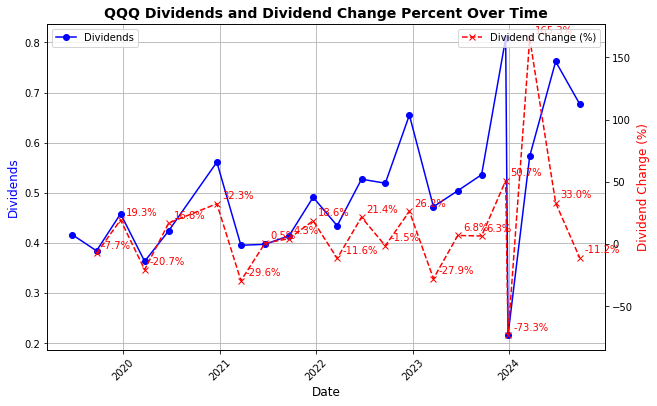

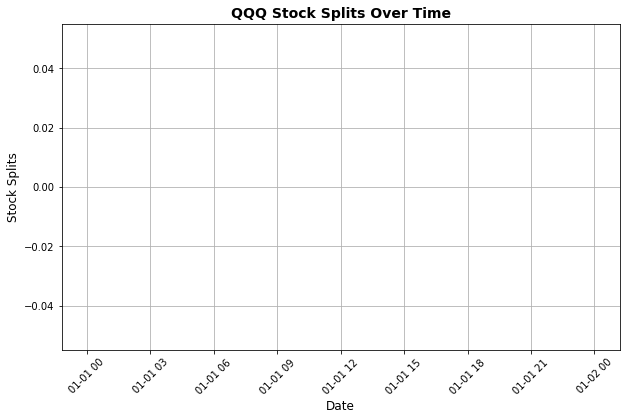

In [11]:
# read in data
index_tickers_list = get_index_tickers_list(MARKET)
interest_rate_df_dict = get_interest_rate(MARKET)

comparable_tickers = {'type': {}, 'list': []}
if MARKET == 'AU':
    asx_companies_directory_df = get_asx_companies_directory()
    asx_gics_df = get_asx_gics()

    # get same gics tickers
    AU_top_list_dict = get_top_ASX_companies_list(asx_companies_directory_df)
    ASX_ticker_gics_dict = get_ASX_ticker_gics(TICKER, asx_gics_df)
    same_gics_ASX_tickers_dict = get_same_gics_ASX_tickers(asx_gics_df,
                                                           ASX_ticker_gics_dict, AU_top_list_dict)

    comparable_ASX_tickers_dict = get_comparable_ASX_tickers(
        TICKER, same_gics_ASX_tickers_dict)
    if ASX_ticker_gics_dict['Sector'] is not 'Unknown':
        market_value_rank = get_market_value_rank(
            TICKER, asx_gics_df)
        print(market_value_rank,)
    print(
        ASX_ticker_gics_dict['Sector'], ASX_ticker_gics_dict['Industry'])

    same_industry_ASX_tickers_mcap_df = get_same_gics_ASX_MCap_weights(TICKER,
                                                                       asx_companies_directory_df, comparable_ASX_tickers_dict)

    # market value and weight
    same_industry_tickers_mcap_df = get_same_industry_tickers_mcap(
        same_industry_ASX_tickers_mcap_df)
    display(same_industry_tickers_mcap_df)

    ticker_mv_df = get_AU_ticker_mv_df(asx_companies_directory_df, TICKER)
    display(ticker_mv_df)

    ticker_proportion_of_market = get_AU_ticker_proportion_of_market(
        ticker_mv_df, same_industry_tickers_mcap_df)
    print(round(ticker_proportion_of_market, 2))

    plot_gics_mcap_weights(TICKER, same_industry_tickers_mcap_df)

    same_gics_industry_weight_dict = get_same_AU_gics_industry_weight_dict(
        same_industry_tickers_mcap_df)

# get historic prices
analysis_needed_ticker_list = get_analysis_needed_ticker_list(
    TICKER, index_tickers_list, comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers)
historical_prices_dict = get_historical_prices_for_interested_list(
    analysis_needed_ticker_list, index_tickers_list, historical_prices_dict, MARKET)

# get historical returns
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['monthly'], 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['quarterly'], 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['annualy'], 'Y')

# get GICS industry weighted returns
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if MARKET == 'AU' else None,
    index_tickers_list, 'M', comparable_tickers=comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if MARKET == 'AU' else None,
    index_tickers_list, 'Q', comparable_tickers=comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if MARKET == 'AU' else None,
    index_tickers_list, 'Y', comparable_tickers=comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers)

# get stats based on returns
stats_df = get_monthly_stats_for_all_tickers(
    monthly_returns_df_dict, comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers, index_tickers_list, same_industry_ASX_tickers_mcap_df if TICKER == 'AU' else None, TICKER, first_end_of_quarter, last_end_of_quarter, MARKET)
plot_key_ticker_stats_table(
    stats_df, TICKER, comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers, index_tickers_list)

# correlation chart
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)
plot_correlation(correlation_df, ticker=TICKER)

# plot returns
# interested ticker
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

if MARKET == 'AU' and len(comparable_ASX_tickers_dict['list']) > 0:
    plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                    'quarterly_returns_df_dict': quarterly_returns_df_dict,
                    'yearly_returns_df_dict': yearly_returns_df_dict,
                    'ticker': 'GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else 'GICS S.WMean',
                    'first_end_of_quarter': first_end_of_quarter,
                    'last_end_of_quarter': last_end_of_quarter,
                    'underlying_ticker': TICKER})

plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD' if MARKET == 'AU' else '^GSPC' if MARKET == 'US' else '^HSI' if MARKET == 'HK' else '000300.SS' if MARKET == 'CN' else None,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_ASX_tickers_dict if MARKET == 'AU' else comparable_tickers, 'market': MARKET}
                         )

# price movement
plot_close_price_with_dollar_lines(TICKER, historical_prices_dict)

# dividends
historical_dividends = get_historical_dividends(
    TICKER, historical_prices_dict, MARKET)
plot_dividends(TICKER, historical_dividends, historical_prices_dict, MARKET)

# historical splits
historical_splits = get_historical_splits(
    TICKER, historical_prices_dict, MARKET)
plot_splits_over_time(TICKER, historical_prices_dict, MARKET)

# Fundamentals

In [12]:
got_fundamentals = False

try:
    if not (MARKET == 'AU' and ASX_ticker_gics_dict['Sector'] == 'Unknown' and ASX_ticker_gics_dict['Industry'] == 'Unknown'):

        # get fundamentals for ticker of interest
        interested_ticker_raw_fundamentals_stats, \
            interested_ticker_key_interested_fundamentals_stats, \
            interested_ticker_key_interested_fundamentals_stats_diff, \
            object = get_fundamentals_dfs(
                first_end_of_quarter, historical_prices_dict,
                TICKER, MARKET)
        # create tables for fundamentals for ticker of interest
        plot_raw_fundamentals_stats_table(
            interested_ticker_raw_fundamentals_stats, TICKER)
        plot_key_fundamentals_multipliers_table(
            interested_ticker_key_interested_fundamentals_stats, TICKER)
        plot_key_fundamentals_multipliers_diff_table(
            interested_ticker_key_interested_fundamentals_stats_diff, TICKER)

        # get fundamentals for comparable tickers
        if MARKET == 'AU':

            # get raw fundamentals stats for comparable tickers
            raw_fundamentals_stats_dict, key_interested_stats_dict, object_dict = get_raw_fundamentals_stats(
                comparable_ASX_tickers_dict, first_end_of_quarter, historical_prices_dict, MARKET)

            # aggregate and integrate the fundamentals stats for comparable tickers
            agg_interpolated_fundamentals_stats_df_dict = get_agg_interpolated_fundamentals_stats(
                raw_fundamentals_stats_dict, interested_ticker_key_interested_fundamentals_stats_diff)

            # get key interested fundamental stats from the interpolated fundamentals for comparable tickers
            key_interested_fundamentals_stats_dict, key_interested_fundamentals_stats_diff_dict = get_key_interested_fundamentals_stats_for_comparable(
                agg_interpolated_fundamentals_stats_df_dict, object_dict, first_end_of_quarter, historical_prices_dict)

            # get weighted average of the key interested fundamentals stats for the GICS industry
            weighted_GICS_key_interested_fundamentals_stats = get_weighted_fundamentals(
                key_interested_fundamentals_stats_dict, same_gics_industry_weight_dict)
            weighted_GICS_key_interested_fundamentals_stats.index = weighted_GICS_key_interested_fundamentals_stats.index

            plot_key_fundamentals_multipliers_table(
                weighted_GICS_key_interested_fundamentals_stats.astype(float).round(2),  f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

            # get percentage change for key interested fundamental stats for the weighted average of the GICS industry
            weighted_GICS_key_interested_fundamentals_stats_diff = get_key_interested_fundamentals_stat_diff(
                weighted_GICS_key_interested_fundamentals_stats)
            weighted_GICS_key_interested_fundamentals_stats_diff.index = interested_ticker_key_interested_fundamentals_stats_diff.index

            plot_key_fundamentals_multipliers_diff_table(
                weighted_GICS_key_interested_fundamentals_stats_diff, f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

        else:
            weighted_GICS_key_interested_fundamentals_stats = pd.DataFrame()

        # plot the comparison of key interested fundamentals for the ticker of interest and the weighted average of the GICS industry
        plot_key_fundamentals_multipliers(
            interested_ticker_key_interested_fundamentals_stats, weighted_GICS_key_interested_fundamentals_stats, TICKER, {})

        got_fundamentals = True

except ValueError as e:
    print('Error:', e)

Missing column from balance sheet for ticker QQQ: 'Total Debt'
Missing column from balance sheet for ticker QQQ: 'Stockholders Equity'
Missing column from balance sheet for ticker QQQ: 'Share Issued'
Missing column from balance sheet for ticker QQQ: 'Current Liabilities'
Missing column from balance sheet for ticker QQQ: 'Current Assets'
Missing column from balance sheet for ticker QQQ: 'Total Assets'
Missing column from balance sheet for ticker QQQ: 'Total Liabilities Net Minority Interest'
Error: No objects to concatenate


PDF

In [13]:
got_fundamentals

False

In [14]:
if MARKET == 'AU' and got_fundamentals:
    # create pdf
    create_pdf(**{
        'ASX_ticker_gics_dict': ASX_ticker_gics_dict,
        'comparable_ASX_tickers_dict': comparable_ASX_tickers_dict,
        'ticker_mv_df': ticker_mv_df,
        'same_industry_tickers_mcap_df': same_industry_tickers_mcap_df,
        'got_fundamentals': got_fundamentals,
        'TICKER': TICKER,
        'MARKET': MARKET,
        'market_value_rank': market_value_rank
    })
else:
    create_pdf(**{
        'got_fundamentals': got_fundamentals,
        'TICKER': TICKER,
        'MARKET': MARKET,
    })